# 07. 성능향상 실습
---





```
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, glob
```

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, glob

## 과제: 개 고양이 분류 모델 만들기

아래 텐서플로우 글을 참고하세요

https://www.tensorflow.org/tutorials/images/transfer_learning?hl=ko

---
### **데이터셋**
---



<p align='center'>
<img src=https://www.tensorflow.org/tutorials/images/transfer_learning_files/output_K5BeQyKThC_Y_0.png?hl=ko  width=400>
</p>


#### **이미지 데이터 경로 설정**

* 데이터 불러오기
  * https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

In [ ]:
from tensorflow.keras import utils

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
valid_dir = os.path.join(PATH, 'validation')

* 데이터 경로 확인

In [ ]:
! ls /root/.keras/datasets/cats_and_dogs_filtered/train

cats  dogs


* 데이터 개수 확인

In [ ]:
for class_name in ['cats', 'dogs']:
  # 각 폴더의 파일들을 확인
  f_list = glob.glob('%s/%s/*jpg'%(train_dir, class_name))
  print(class_name)
  print(len(f_list))

cats
1000
dogs
1000


* 이미지 확인

(-0.5, 319.5, 238.5, -0.5)

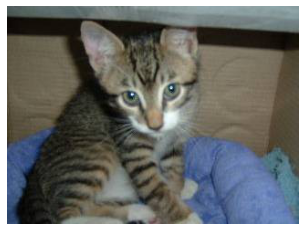

In [ ]:
class_name = 'cats'
cd_list = glob.glob('%s/%s/*jpg'%(train_dir, class_name))
img = plt.imread(cd_list[5])
plt.imshow(img)
plt.axis('off')

#### **텐서플로우 데이터셋 준비**

In [ ]:
from tensorflow.keras import preprocessing

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

valid_dataset = image_dataset_from_directory(valid_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
val_batches = tf.data.experimental.cardinality(valid_dataset)
test_dataset = valid_dataset.take(val_batches // 5)
valid_dataset = valid_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(valid_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


* 데이터셋 시각화

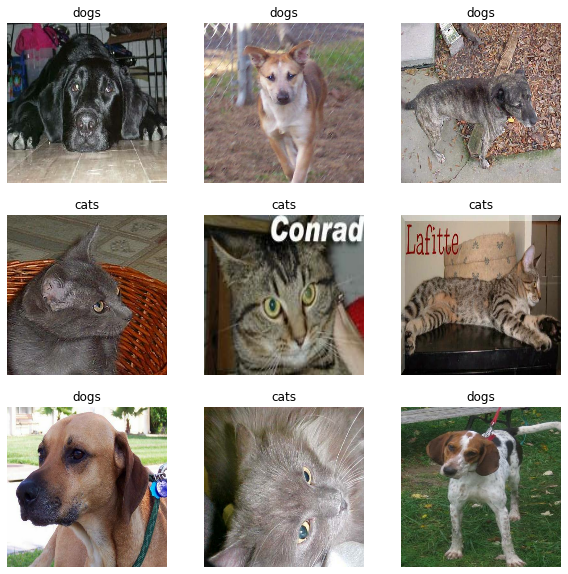

In [ ]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

---
### **성능 향상 기법 적용**
---

In [ ]:
from tensorflow.keras import layers, models, losses, optimizers
aug = tf.keras.Sequential([
      layers.experimental.preprocessing.RandomFlip(),
      layers.experimental.preprocessing.RandomRotation(0.2)
])

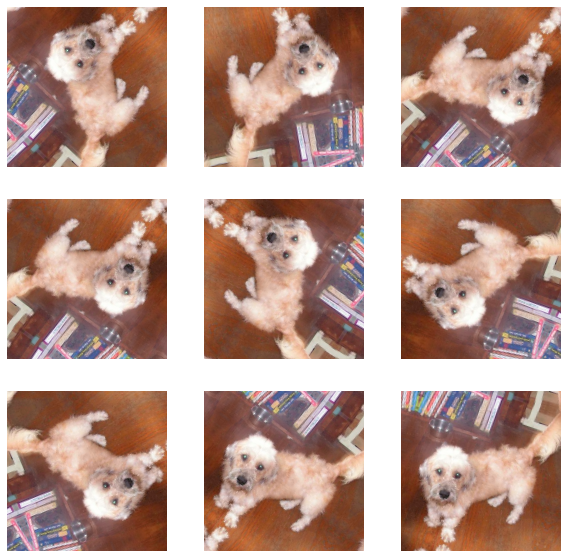

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    aug_image = aug(tf.expand_dims(first_image, 0))
    plt.imshow(aug_image[0] / 255)
    plt.axis('off')

In [ ]:
from tensorflow.keras import applications

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB1(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.summary()

Model: "efficientnetb1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 160, 160, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 160, 160, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 161, 161, 3)  0           ['normalization[0][0

In [ ]:
base_model.trainable = False

In [ ]:
x = layers.Input(shape=(160, 160, 3))
z = aug(x)  # 데이터 증강
z = applications.efficientnet.preprocess_input(z)   # efficientnet에 맞는 프로세싱
z = base_model(z, training=False)
z = layers.GlobalAveragePooling2D()(z)
# z = layers.Flatten()
z = layers.Dropout(0.2)(z)
y = layers.Dense(1, activation='sigmoid')(z)

transfer = models.Model(x, y)
transfer.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 efficientnetb1 (Functional)  (None, 5, 5, 1280)       6575239   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                             

In [ ]:
from tensorflow.keras import callbacks

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                        factor = 0.2,
                                        patience = 3,
                                        min_lr = 0.000001)
ckp = callbacks.ModelCheckpoint('model.h5', save_best_only=True)

In [ ]:
transfer.compile(loss = losses.SparseCategoricalCrossentropy(),
                 optimizer = optimizers.RMSprop(learning_rate=0.0001),
                 metrics = ['acc'])

In [ ]:
history_transfer = transfer.fit(train_dataset,
                                validation_data = valid_dataset,
                                epochs = 20,
                                callbacks = [reduce_lr, ckp])

Epoch 1/20
63/63 [==============================] - ETA: 0s - loss: 1.2590 - acc: 0.4840

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


63/63 [==============================] - 35s 349ms/step - loss: 1.2590 - acc: 0.4840 - val_loss: 1.0791 - val_acc: 0.6955 - lr: 1.0000e-04
Epoch 2/20
63/63 [==============================] - 15s 221ms/step - loss: 0.8200 - acc: 0.7035 - val_loss: 0.7393 - val_acc: 0.8738 - lr: 1.0000e-04
Epoch 3/20
63/63 [==============================] - 14s 215ms/step - loss: 0.6013 - acc: 0.8010 - val_loss: 0.5251 - val_acc: 0.9295 - lr: 1.0000e-04
Epoch 4/20
63/63 [==============================] - 14s 214ms/step - loss: 0.4699 - acc: 0.8455 - val_loss: 0.4127 - val_acc: 0.9394 - lr: 1.0000e-04
Epoch 5/20
63/63 [==============================] - 14s 215ms/step - loss: 0.3922 - acc: 0.8650 - val_loss: 0.3289 - val_acc: 0.9443 - lr: 1.0000e-04
Epoch 6/20
63/63 [==============================] - 14s 215ms/step - loss: 0.3629 - acc: 0.8685 - val_loss: 0.2723 - val_acc: 0.9517 - lr: 1.0000e-04
Epoch 7/20
63/63 [==============================] - 14s 223ms/step - loss: 0.3177 - acc: 0.8855 - val_loss: 0.2

**성능평가**

* 평가

In [ ]:
transfer.evaluate(valid_dataset)

26/26 [==============================] - 4s 133ms/step - loss: 0.1100 - acc: 0.9703


[0.11001972109079361, 0.9702970385551453]

* learning curve

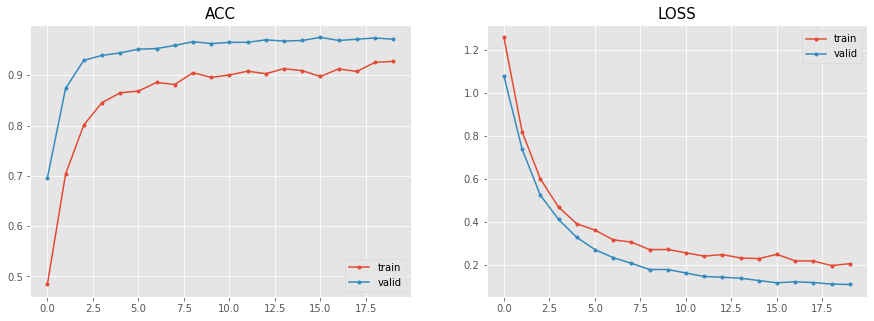

In [ ]:
def plot_lcurve(history):
  plt.style.use('ggplot')
  acc = history.history['acc']
  loss = history.history['loss']
  val_acc = history.history['val_acc']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  plt.title('ACC', fontsize=15)
  plt.plot(acc, marker='.', label='train')
  plt.plot(val_acc, marker='.', label='valid')
  plt.legend()

  plt.subplot(1,2,2)
  plt.title('LOSS', fontsize=15)
  plt.plot(loss, marker='.', label='train')
  plt.plot(val_loss, marker='.', label='valid')     
  plt.legend()

  plt.show()

plot_lcurve(history_transfer)

---
### **모델 사용**
---

* `valid_ds` 로 테스트

(32, 160, 160, 3) (32,)
(32, 5)
[0 0 0 1 1 0 0 1 0 1 1 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 1 0 1 0 1]
[0 0 0 1 1 0 0 1 0 1 1 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 1 0 1 0 1]


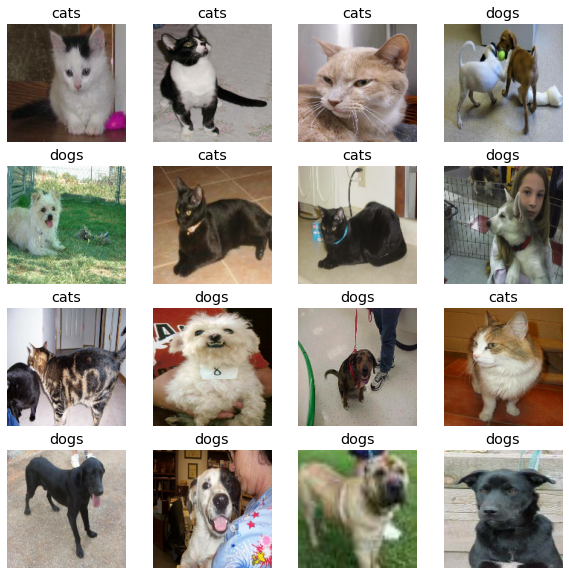

In [ ]:
imgs, labels = valid_dataset.as_numpy_iterator().next()
print(imgs.shape, labels.shape)
preds = transfer.predict_on_batch(imgs)
print(preds.shape)
preds = np.argmax(preds, axis=1)
print(preds)
print(labels)
plt.figure(figsize=(10,10))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(imgs[i].astype("uint8"))
  # plt.title(valid_dataset.class_name[preds[i]])
  plt.title(class_names[preds[i]])
  plt.axis('off')

* 새로운 이미지로 테스트

<PIL.Image.Image image mode=RGB size=160x160 at 0x7F83B7886690>
[1]


(-0.5, 159.5, 159.5, -0.5)

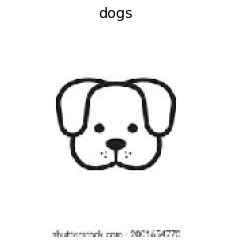

In [ ]:
img_path = 'dog_pic.jpg'
img = preprocessing.image.load_img(img_path,
                                   target_size=(160, 160))
print(img)

img_arr = preprocessing.image.img_to_array(img)
img_arr = tf.expand_dims(img_arr, 0)  # (1, 160, 160, 3)
pred = transfer.predict_on_batch(img_arr)
pred = np.argmax(pred, axis=1)
print(pred)

plt.title(class_names[pred[0]])
plt.imshow(img)
plt.axis('off')

In [ ]:
transfer.save('dogs_and_cats.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


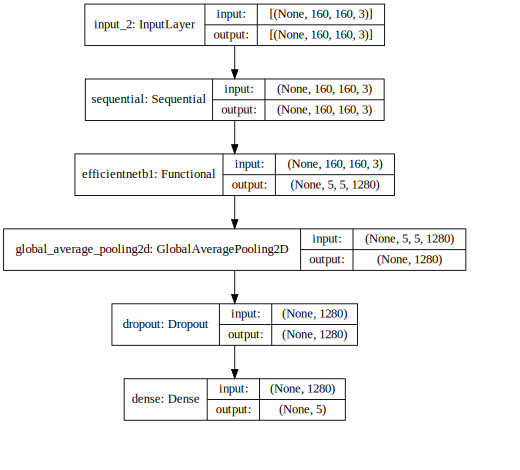

In [ ]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(transfer,show_shapes=True, dpi=65).create(prog='dot',format='svg'))